In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

# from tqdm.notebook import tqdm
from tqdm import tqdm
from algorithm import get_prop, create_R, get_dyn
from functions import (
    forces_dict_2,
    get_lin_var,
    get_lin_var_small_delay,
    get_p_x4_small_delay,
    simulate_traj_g,
)
from setup import (
    setup_matplotlib,
    one_col,
    std_height,
    two_col,
    sim_plt_set,
    num_plt_set,
    eigenv_plt_set,
    exact_plt_set,
    short_plt_set,
)

setup_matplotlib()

np.random.seed(42)

# Linear

In [2]:
s = 1
D = s**2 / 2
sb = 7  # 14
max_t = 10
ntau = 2  # 3
# dx = 0.3
N_x = 81
force = "linear"
x_0 = 0
tau = 1  # 1.4

N_p = 2_000
N_loop = 10

ntau_sim = 60

dt = tau / ntau if tau > 0 else 0.05
N_t = int(max_t / dt) + 1

dt_sim = tau / ntau_sim if tau > 0 else 0.05/15
N_t_sim = int(max_t / dt_sim) + 1

dx = 2 * sb / (N_x - 1)
x_s_x2 = np.arange(-sb, sb + 1e-6, dx)
i_zero = np.argmin((x_s_x2 - x_0) ** 2)
D = s**2 / 2

# sim
pos = simulate_traj_g(
    N_p,
    N_loop,
    N_t_sim,
    ntau_sim,
    s,
    dt_sim,
    x_0,
    force=forces_dict_2[force],
    filter=None,
)
bins = np.arange(-sb - dx / 2, sb + dx / 2 + 1e-6, dx)
sim_hists_raw = np.swapaxes(
    np.apply_along_axis(lambda a: np.histogram(a, bins)[0], 1, pos), 1, 2
)
sim_hists_x2 = sim_hists_raw / np.sum(sim_hists_raw, axis = 2)[:,:,None] / (x_s_x2[1] - x_s_x2[0])
sim_hists_x2_m = np.mean(sim_hists_x2, axis=0)
sim_hists_x2_std = np.std(sim_hists_x2, axis=0)

# num
force_func = forces_dict_2[force] if ntau > 0 else forces_dict_2["no_delay_" + force]
prop = get_prop(x_s_x2, force_func, D, dt)

R, _, end_states = create_R(ntau, prop)
_, hists_x2_raw = get_dyn(R, i_zero, N_t, N_x, ntau, end_states)

hists_x2 = hists_x2_raw / hists_x2_raw.sum(1)[:, None] / (x_s_x2[1] - x_s_x2[0])

# exact
exact_var_x2 = get_lin_var(tau, 0, 1, s)
st_var_x2 = get_lin_var_small_delay(tau, 0, 1, s)

ex_x_x2 = np.linspace(-sb, sb, 500)
exact_pdf_x2 = (
    1 / np.sqrt(2 * np.pi * exact_var_x2) * np.exp(-(ex_x_x2**2) / (2 * exact_var_x2))
)

st_pdf_x2 = (
    1 / np.sqrt(2 * np.pi * st_var_x2) * np.exp(-(ex_x_x2**2) / (2 * st_var_x2))
)

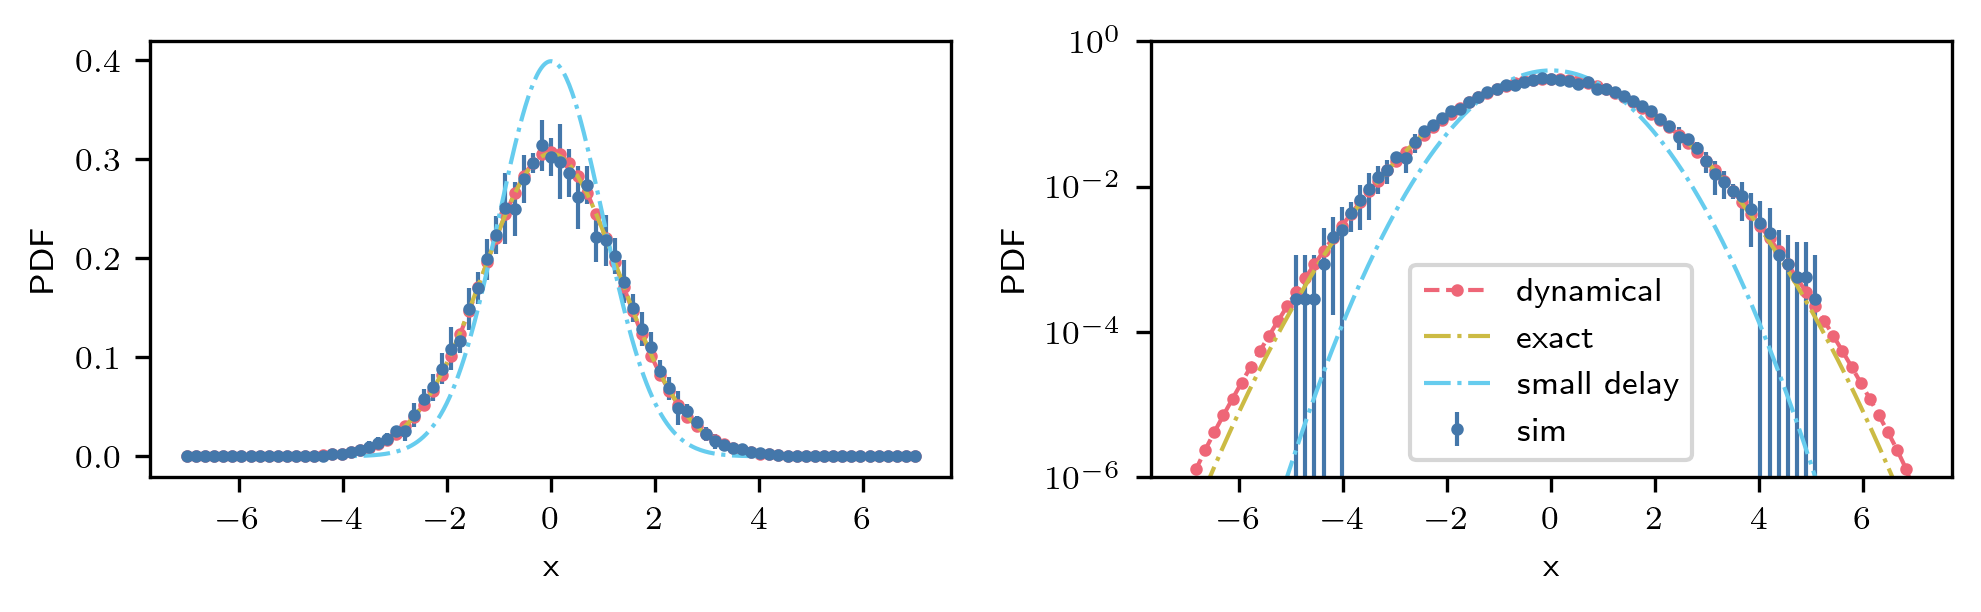

In [3]:
fig, axs = plt.subplots(1,2,figsize = (two_col, std_height))
for ax in axs:
    ax.errorbar(x_s_x2, sim_hists_x2_m[-1], yerr=sim_hists_x2_std[-1], **sim_plt_set, ms = 4)
    ax.plot(x_s_x2, hists_x2[-1], **num_plt_set, ms=4)
    ax.plot(ex_x_x2, exact_pdf_x2, **exact_plt_set)
    ax.plot(ex_x_x2, st_pdf_x2, **short_plt_set)
    ax.set_xlabel("x")
    ax.set_ylabel("PDF")

axs[1].set_yscale('log')
axs[1].set_ylim(1e-6,1e0)
plt.legend()

plt.tight_layout()
plt.savefig(f'graphics/pdf_x2_s{s}.pdf')

# Non linear

In [4]:
s = 1
D = s**2 / 2
max_t = 6  # 2
ntau = 2  # 3
N_x = 81  # 25
force = "cubic"
tau = 0.4
sb = 4
x_0 = 0

N_p = 2_000
N_loop = 10


dt = tau / ntau if tau > 0 else 0.05
N_t = int(max_t / dt) + 1

dx = 2 * sb / (N_x - 1)
x_s_x4 = np.arange(-sb, sb + 1e-6, dx)
i_zero = np.argmin((x_s_x4 - x_0) ** 2)
D = s**2 / 2

force_func = forces_dict_2[force] if ntau > 0 else forces_dict_2["no_delay_" + force]

# sim
ntau_sim = 60
dt_sim = tau / ntau_sim if tau > 0 else 0.05 / 15
N_t_sim = int(max_t / dt_sim) + 1
pos = simulate_traj_g(
    N_p,
    N_loop,
    N_t_sim,
    ntau_sim,
    s,
    dt_sim,
    x_0,
    force=force_func,
    filter=None,
)
bins = np.arange(-sb - dx / 2, sb + dx / 2 + 1e-6, dx)
sim_hists_raw = np.swapaxes(
    np.apply_along_axis(lambda a: np.histogram(a, bins)[0], 1, pos), 1, 2
)
sim_hists_x4 = sim_hists_raw / np.sum(sim_hists_raw, axis = 2)[:,:,None] / (x_s_x4[1] - x_s_x4[0])
sim_hists_x4_m = np.mean(sim_hists_x4, axis=0)
sim_hists_x4_std = np.std(sim_hists_x4, axis=0)

# num
prop = get_prop(x_s_x4, force_func, D, dt)

R, _, end_states = create_R(ntau, prop)
_, hists_x4_raw = get_dyn(R, i_zero, N_t, N_x, ntau, end_states)
hists_x4 = hists_x4_raw /hists_x4_raw.sum(1)[:,None]/ (x_s_x4[1] - x_s_x4[0])

# small delay
ex_x_x4 = np.linspace(-sb, sb, 500)
sd_var_x4_raw = get_p_x4_small_delay(ex_x_x4, tau)
sd_var_x4 = sd_var_x4_raw / sd_var_x4_raw.sum() / (ex_x_x4[1] - ex_x_x4[0])

/home/nils/Programmieren/overdampedDelayHarmonicOscillator/paper/functions.py:374: RuntimeWarning: overflow encountered in power
  res_array[:] = -(x_t**3)
/home/nils/Programmieren/overdampedDelayHarmonicOscillator/paper/functions.py:310: RuntimeWarning: invalid value encountered in add
  pos[:, :, i] = pos[:, :, i - 1] + vel[:, :, i - 1] * dt


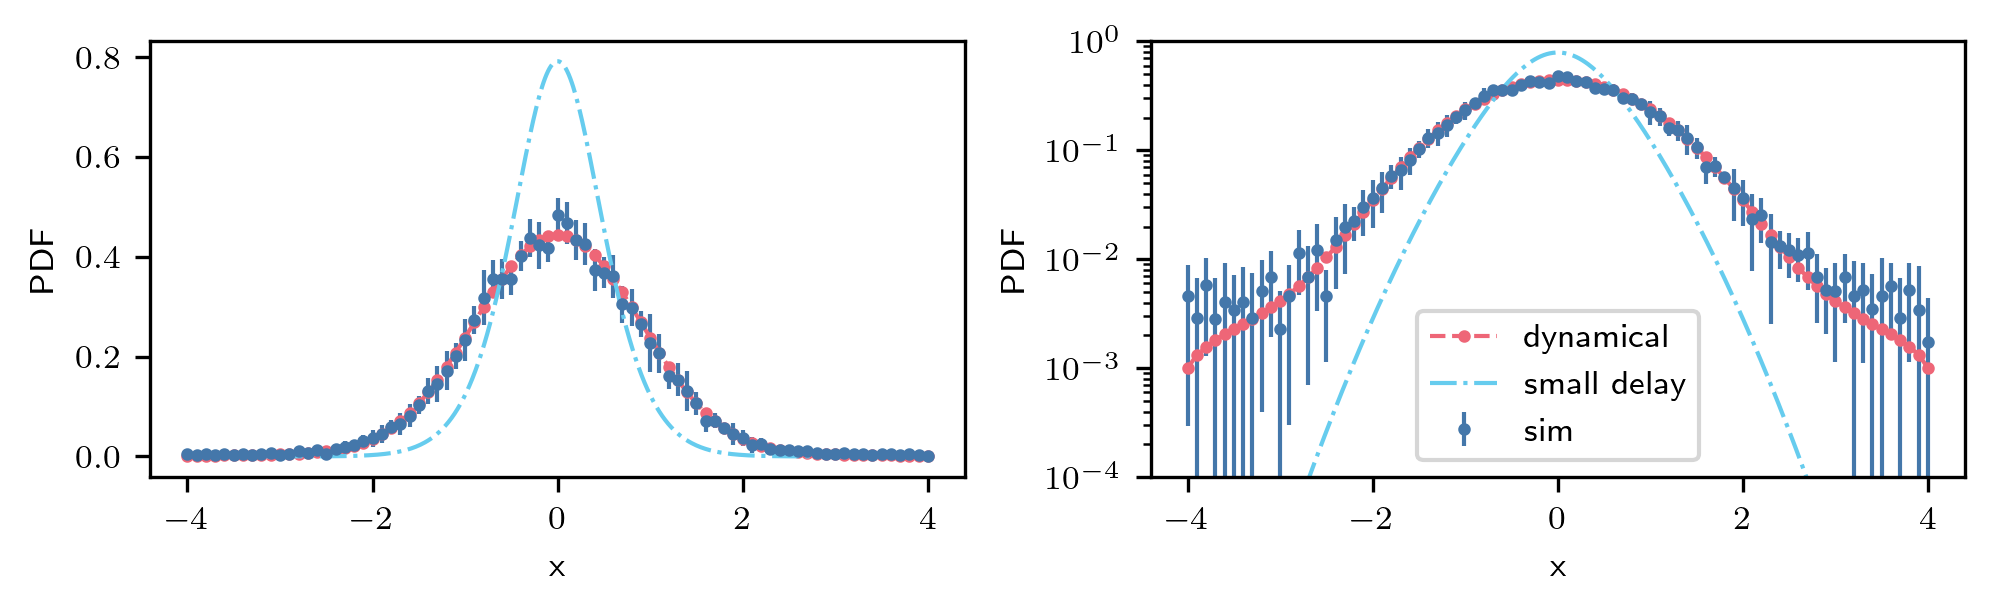

In [5]:
fig, axs = plt.subplots(1,2,figsize = (two_col, std_height))
for ax in axs:
    ax.errorbar(x_s_x4, sim_hists_x4_m[-1], yerr=sim_hists_x4_std[-1], **sim_plt_set, ms = 4)
    ax.plot(x_s_x4, hists_x4[-1], **num_plt_set, ms = 4)
    ax.plot(ex_x_x4, sd_var_x4, **short_plt_set)
    ax.set_xlabel("x")
    ax.set_ylabel("PDF")

axs[1].set_yscale('log')
axs[1].set_ylim(1e-4,1e0)
plt.legend()
plt.tight_layout()
plt.savefig('graphics/pdf_x4.pdf')

# Cusp 

In [2]:
k = 1
border = 0
x_0 = -1
N_x_border = 10.5
max_t = 26
ntau = 2
force = "cusp_force"
force_func = (
        forces_dict_2[force] if ntau > 0 else forces_dict_2["no_delay_" + force]
)

tau = 1
s = 0.5


dx = (border - x_0) / N_x_border
sb = N_x_border * 4 * dx


N_p = 2_000
N_loop = 10

ntau_sim = 60

D = s**2 / 2
dt = tau / ntau if tau > 0 else 0.05
N_t = int(max_t / dt)

dt_sim = tau / ntau_sim if tau > 0 else 0.002
N_t_sim = int(max_t / dt_sim)

N_x = int((2 * sb) / dx) + 1
sbs = [-sb,sb]
dx = (sbs[1] - sbs[0]) / (N_x - 1)
x_s_cusp = sbs[0] + np.arange(N_x) * dx
i_zero = np.argmin((x_s_cusp - x_0) ** 2)

pos = simulate_traj_g(
            N_p,
            N_loop,
            N_t_sim,
            ntau_sim,
            s,
            dt_sim,
            x_0,
            force=force_func,
            filter=None,
        )

bins = np.arange(sbs[0]- dx / 2, sbs[1] + dx / 2 + 1e-6, dx)
sim_hists_raw = np.swapaxes(
    np.apply_along_axis(lambda a: np.histogram(a, bins)[0], 1, pos), 1, 2
)
sim_hists_cusp = sim_hists_raw / np.sum(sim_hists_raw, axis = 2)[:,:,None] / (x_s_cusp[1] - x_s_cusp[0])
sim_hists_cusp_m = np.mean(sim_hists_cusp, axis=0)
sim_hists_cusp_std = np.std(sim_hists_cusp, axis=0)
# num
prop = get_prop(x_s_cusp, force_func, D, dt)

R, _, end_states = create_R(ntau, prop)
_, hists_cusp_raw = get_dyn(R, i_zero, N_t, N_x, ntau, end_states)

hists_cusp = hists_cusp_raw / hists_cusp_raw.sum(1)[:, None] / (x_s_cusp[1] - x_s_cusp[0])

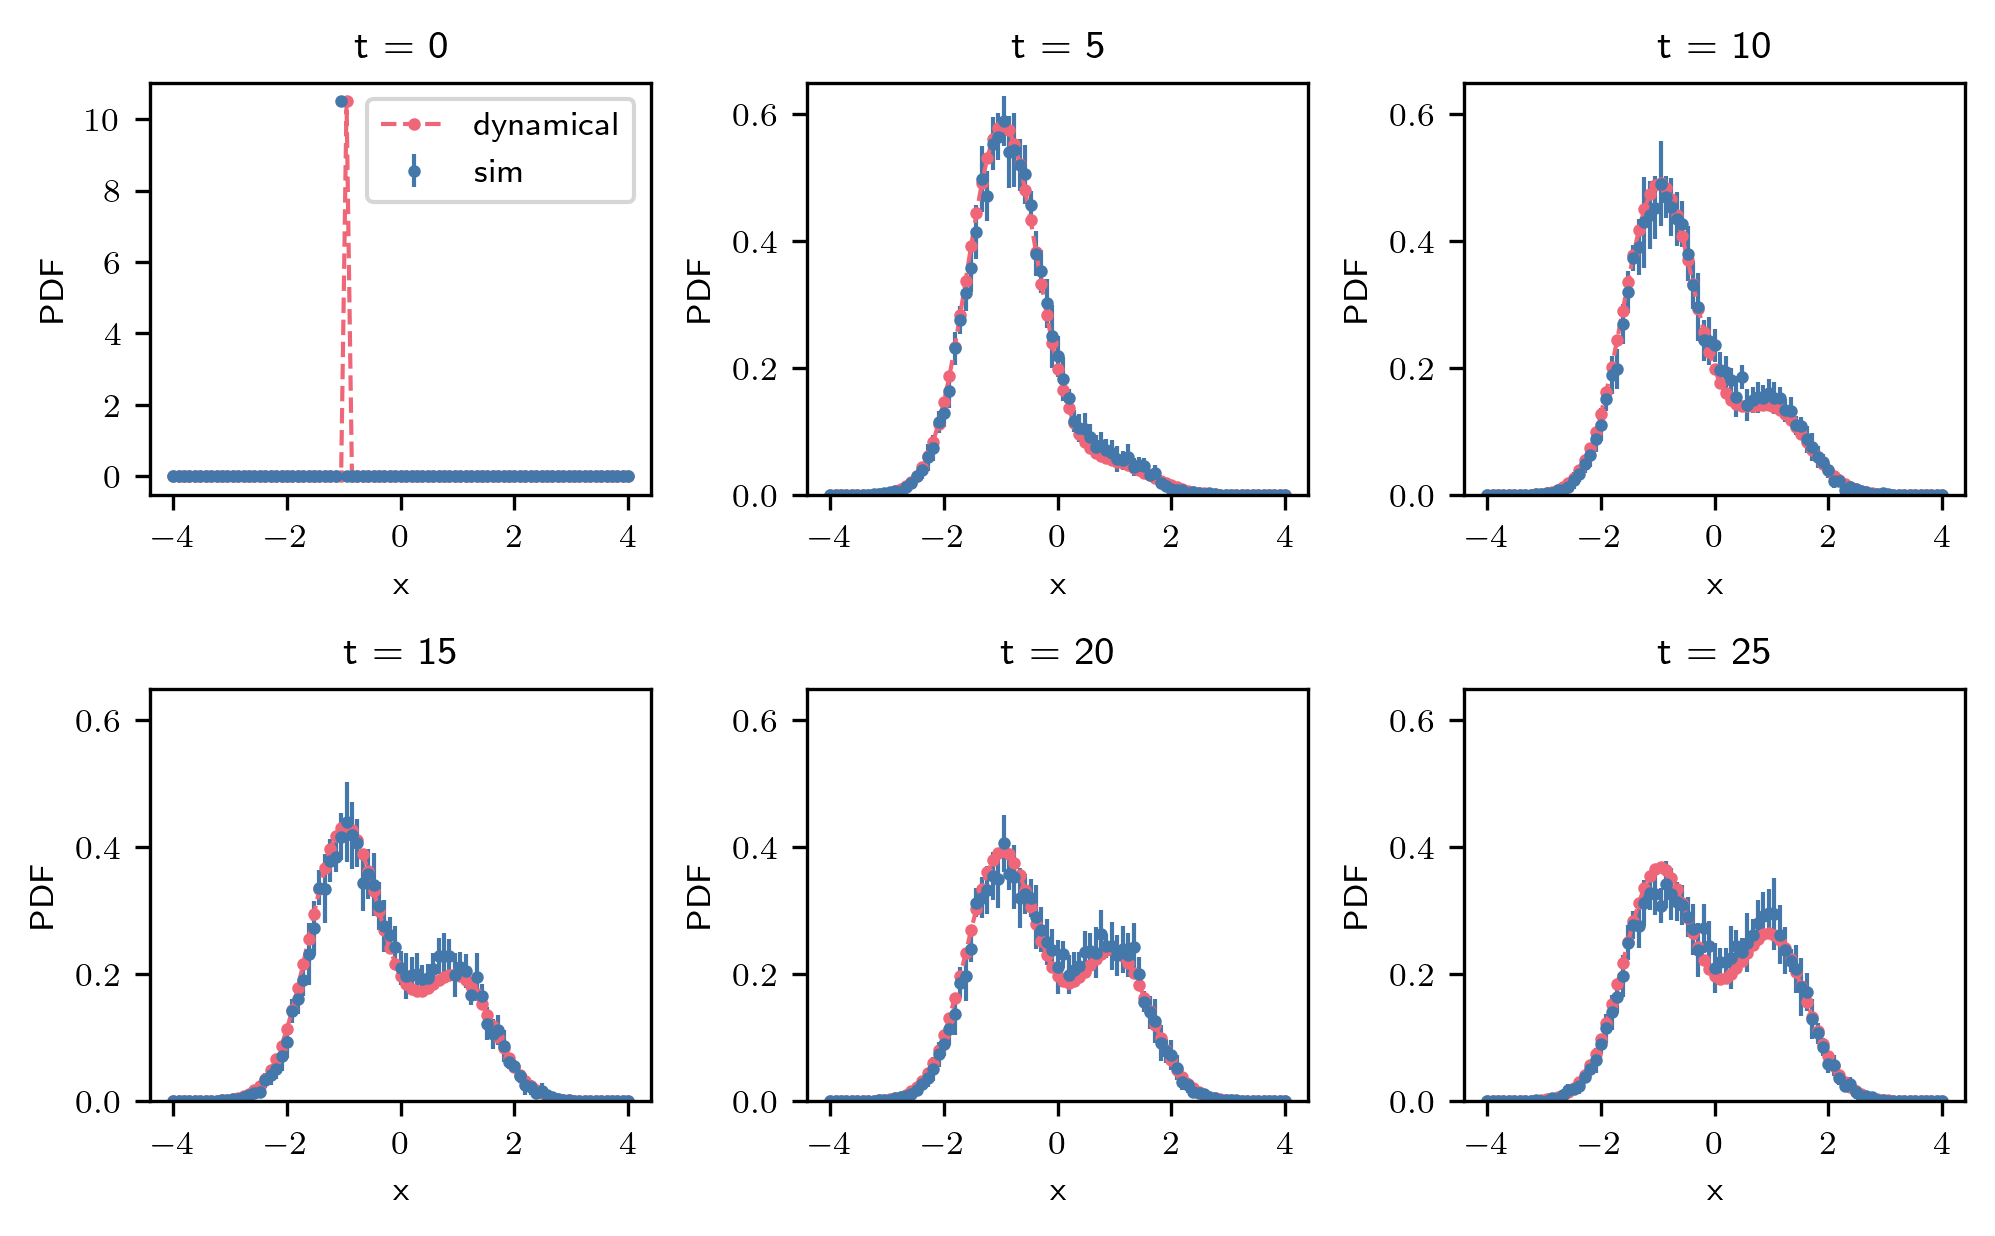

In [4]:
fig,axs = plt.subplots(2,3, figsize=(two_col, 2*std_height))
axs = axs.flatten()
for i in range(6):
    axs[i].errorbar(x_s_cusp, sim_hists_cusp_m[10*ntau_sim//ntau*i+ntau_sim], sim_hists_cusp_std[10*ntau_sim//ntau*i+ntau_sim], **sim_plt_set, ms = 4)
    axs[i].plot(x_s_cusp, hists_cusp[10*i], **num_plt_set, ms = 4)
    axs[i].set_xlabel('x')
    axs[i].set_ylabel('PDF')
    axs[i].set_title(f"t = {round(dt*10*i)}")
    if i > 0:
        axs[i].set_ylim(0,0.65)

axs[0].legend()

plt.tight_layout()
plt.savefig('graphics/pdf_cusp.pdf')